In [1]:



import matplotlib.pyplot as plt
from typing import List
from chinese_checkers.simulation import S3SimulationCatalog, SimulationMetadata, SimulationData
from chinese_checkers.cnn import CnnEncoderExperience
import pandas as pd

from dataclasses import asdict
import random
from tqdm import tqdm
from chinese_checkers.experience import ExperienceData, ExperienceCatalog, ExperienceMetadata

In [2]:
sim_catalog = S3SimulationCatalog()
# name = "dql-cnn-v002-vs-bootstrap-p0-simulation"
sim_metadata: List[SimulationMetadata] = sim_catalog.list_datasets()
pd.DataFrame([asdict(m) for m in sim_metadata])

,player_count,board_size,max_game_length,winning_player,name,version
0,2,4,1000,0,bad-player-3-bootstrap-simulation,v0.0.1
1,2,4,1000,3,bad-player-3-bootstrap-simulation,v0.0.1
2,2,4,1000,None,bad-player-3-bootstrap-simulation,v0.0.1
3,2,4,1000,0,bootstrap-p3-010-simulation,v0.0.1
4,2,4,1000,3,bootstrap-p3-010-simulation,v0.0.1
5,2,4,1000,0,bootstrap-simulation-p0d05-p0d25,v0.0.1
6,2,4,1000,3,bootstrap-simulation-p0d05-p0d25,v0.0.1
7,2,4,1000,0,bootstrap-simulation-p0d15,v0.0.1
8,2,4,1000,3,bootstrap-simulation-p0d15,v0.0.1
9,2,4,1000,0,bootstrap-simulation,v0.0.1


In [3]:
player_count = 2

simulations: List[SimulationData] = [
    dataset
    for metadata in sim_metadata
    if metadata.player_count == player_count
        # and metadata.name == name 
    for dataset in sim_catalog.load_dataset(metadata)
]
print(f"Found {len(simulations)} datasets for player_count: {player_count}.")

Found 42615 datasets for player_count: 2.


In [4]:
exp_catalog = ExperienceCatalog()
# v0.0.4 punishes the player for keeping pieces in the starting area.  It also rewards positions in the target area.
# 
pd.DataFrame([asdict(e) for e in exp_catalog.list_datasets() if e.generator_name == "CnnExperienceEncoder-v005"])

""


In [5]:
exp_encoder = CnnEncoderExperience("v005")

In [15]:
random.shuffle(simulations)
total_experiences = 0
with tqdm(simulations, desc="Generating experiences") as pbar:
    for simulation in pbar:
        experiences = exp_encoder.encode(simulation)
        exp_catalog.add_record_list(experiences)
        total_experiences += len(experiences)
        pbar.set_description(f"Generating experiences (Last generated: {len(experiences)}, Total {total_experiences})")

Generating experiences (Last generated: 393, Total 248438):   1%|▏         | 620/42615 [1:44:34<118:02:45, 10.12s/it] 


KeyboardInterrupt: 

In [ ]:
print(exp_encoder.encode(simulations[0]))

In [18]:
# Initialize tqdm with detailed postfix for metadata info
generator_name="CnnExperienceEncoder-v005"
player_count = 2
current_player = "0"
board_size = 4

catalog = ExperienceCatalog()
dataset_metadata: List[ExperienceMetadata] = catalog.list_datasets()
experiences: List[ExperienceData] = []
progress_bar = tqdm(dataset_metadata, desc="Loading datasets")

for metadata in progress_bar:
    # Dynamically set postfix with metadata name and generator name
    progress_bar.set_postfix(name=metadata.name, generator=metadata.generator_name)

    if (
        metadata.player_count == str(player_count)
        and metadata.current_player == current_player
        and metadata.generator_name == generator_name
        and metadata.board_size == str(board_size)
    ):
        experiences.extend(catalog.load_dataset(metadata))

print(f"Found {len(experiences)} datasets for player_count: {player_count}, and current_player: {current_player}.")

Loading datasets: 100%|██████████| 205/205 [01:46<00:00,  1.92it/s, generator=CnnExperienceEncoder-v005, name=bootstrap-0d01-vs-dql-v004]             

Found 157792 datasets for player_count: 2, and current_player: 0.


p0_win_count 55427, p3_win_count 87966


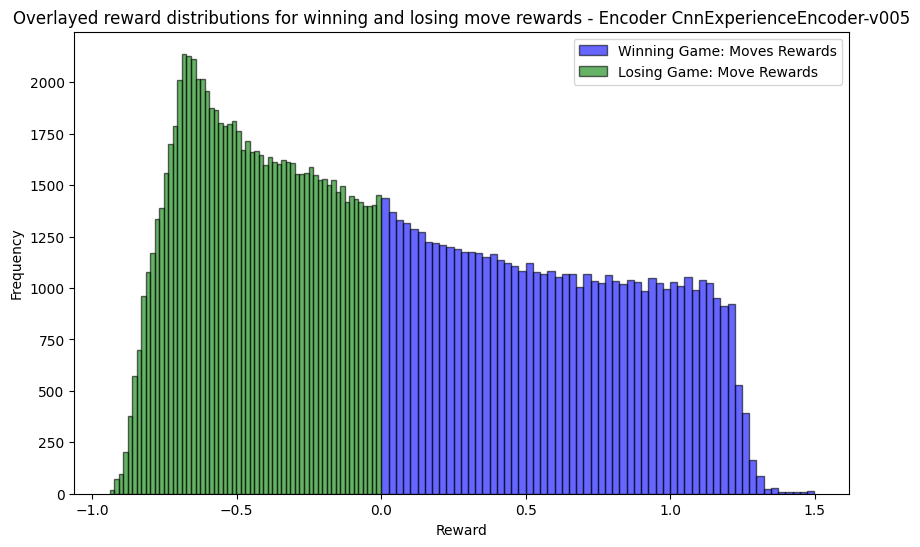

In [19]:
class ExperienceAnalysis:

    experience: List[ExperienceData]

    def __init__(self, experiences: List[ExperienceData]):
        self.experiences: List[ExperienceData] = experiences

    def print_winner_counts(self):
        p0_win_count = len([e for e in self.experiences if e.metadata.winning_player == "0"])
        p3_win_count = len([e for e in self.experiences if e.metadata.winning_player == "3"])
        print(f"p0_win_count {p0_win_count}, p3_win_count {p3_win_count}")


    def check_feature_overlap(self):
        # Extract rewards for each player group
        win_rewards = [e.data.reward.item() for e in self.experiences if e.metadata.winning_player == "0"]
        loss_rewards = [e.data.reward.item() for e in self.experiences if e.metadata.winning_player == "3"]


        plt.figure(figsize=(10, 6))
        plt.hist(win_rewards, bins=60, alpha=0.6, color='blue', edgecolor='black', label="Winning Game: Moves Rewards")
        plt.hist(loss_rewards, bins=60, alpha=0.6, color='green', edgecolor='black', label="Losing Game: Move Rewards")

        plt.title(f"Overlayed reward distributions for winning and losing move rewards - Encoder {generator_name}")
        plt.xlabel("Reward")
        plt.ylabel("Frequency")
        plt.legend()
        plt.savefig(f'win-loss-rewards-{generator_name}.png')
        plt.show()

an = ExperienceAnalysis(experiences)
an.print_winner_counts()
an.check_feature_overlap()